In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy
import pathlib 
from tqdm import tqdm
import os 
from scipy import optimize

covdir = "/Volumes/HNSD01/storage/TSMA_validation_cov"
outdir = "./output"
path_to_main_output = os.path.join(outdir, "analysis_output")
path_to_02_output = os.path.join(path_to_main_output, "01_output")
os.system(f"mkdir -p {path_to_02_output}")

# get all CpG sites from atlas TSMA
atlas_cpgdf = pd.read_csv("./assets/tsma-published/atlas_cpgs.csv", index_col = [0])
atlas_cpgdf["cpg"] = atlas_cpgdf[["chrom", "pos"]].apply(lambda x: f"chr{x[0]}:{x[1]}-{x[1] + 1}", axis = 1 )

all_covfiles = [item for item in pathlib.Path(covdir).glob("*.cov")]

resdf = pd.DataFrame()
for file in tqdm(all_covfiles):
    sampleid = file.name.replace(".cov", "").split("_")[0].split("-")[1]
    tmpdf = pd.read_csv(file, sep = "\t", header = None)
    tmpdf.columns = ["chrom", "start", "end", "methyl", "countC", "countT"]
    tmpdf["cpg"] = tmpdf[["chrom", "start", "end"]].apply(lambda x: f"{x[0]}:{x[1]}-{x[2]}", axis = 1 )

    tmpdf = tmpdf[tmpdf["cpg"].isin(atlas_cpgdf["cpg"].to_list())]
    tmpdf = tmpdf.merge(atlas_cpgdf[["cpg", "region"]], right_on = "cpg", left_on = "cpg")
    tmpdf = tmpdf.groupby("region")["methyl"].mean().reset_index()
    tmpdf["methyl"] = tmpdf["methyl"] / 100.0
    tmpdf.columns = ["region", sampleid]

    atlas_labels = ["Liver", "Breast", "Gastric", "Lung", "CRC", "WBC"]
    atlasdf = pd.read_csv("./assets/tsma-published/final_atlas.csv")

    deconv_atlas = atlasdf.set_index("label").T.reset_index()
    deconv_atlas.columns = ["region"] + list(deconv_atlas.columns[1:])
    deconv_atlas = deconv_atlas.merge(tmpdf.reset_index(), right_on = "region", left_on = "region")
    deconv_atlas = deconv_atlas[~deconv_atlas[sampleid].isna()]
    mixture, residual = optimize.nnls(deconv_atlas[atlas_labels].to_numpy(), deconv_atlas[sampleid].to_numpy())
    mixture /= np.sum(mixture)
    tmp_resdf = pd.DataFrame(data = atlas_labels, columns = ["TOO"])
    tmp_resdf[sampleid] = mixture

    tmp_resdf = tmp_resdf.set_index("TOO").T
    resdf = pd.concat([resdf, tmp_resdf], axis = 0)

metadata = pd.read_excel("./metadata/metadata_TSMA_R8281_R8282.xlsx")[["LABCODE", "TYPE"]]

resdf = resdf.merge(metadata, right_on = "LABCODE", left_on = resdf.index)
resdf.to_excel(os.path.join(path_to_02_output, "deconvo_based_on_CpG_results.xlsx"))    

100%|██████████| 60/60 [08:56<00:00,  8.95s/it]


In [7]:
resdf["binaryLABEL"] = resdf["TYPE"].apply(lambda x: "Control" if x == "Control" else "Cancer")

<Axes: xlabel='binaryLABEL', ylabel='WBC'>

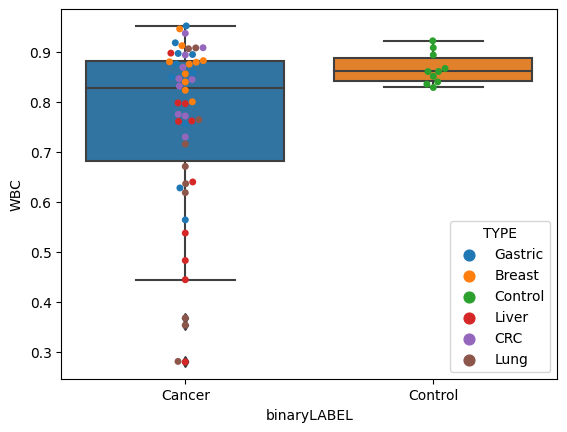

In [15]:
sns.boxplot(data = resdf, x = "binaryLABEL", y = "WBC")
sns.swarmplot(data = resdf, x = "binaryLABEL", y = "WBC", hue = "TYPE")

In [30]:
resdf[resdf["TYPE"] == "Liver"]

,Liver,Breast,Gastric,Lung,CRC,WBC,LABCODE,TYPE,binaryLABEL
6,0.630263,0.011284,0.000000,0.078397,0.000000,0.280056,LBH239TS,Liver,Cancer
13,0.165954,0.000000,0.028299,0.045129,0.000000,0.760618,LBH307TS,Liver,Cancer
14,0.140180,0.003494,0.025560,0.034792,0.000000,0.795974,LBH222TS,Liver,Cancer
18,0.125427,0.015631,0.056862,0.040534,0.000000,0.761546,LBH237TS,Liver,Cancer
20,0.317946,0.057871,0.073778,0.051352,0.016296,0.482757,LBH240TS,Liver,Cancer
34,0.337333,0.021775,0.036814,0.046044,0.020541,0.537493,LBH324TS,Liver,Cancer
35,0.048304,0.000000,0.028581,0.026071,0.000000,0.897044,LBH224TS,Liver,Cancer
40,0.132399,0.000000,0.049765,0.020313,0.000000,0.797524,LBH323TS,Liver,Cancer
45,0.164409,0.084204,0.048642,0.063115,0.000000,0.639630,LBH238TS,Liver,Cancer
50,0.472362,0.000000,0.003669,0.059475,0.020194,0.444300,LBH322TS,Liver,Cancer


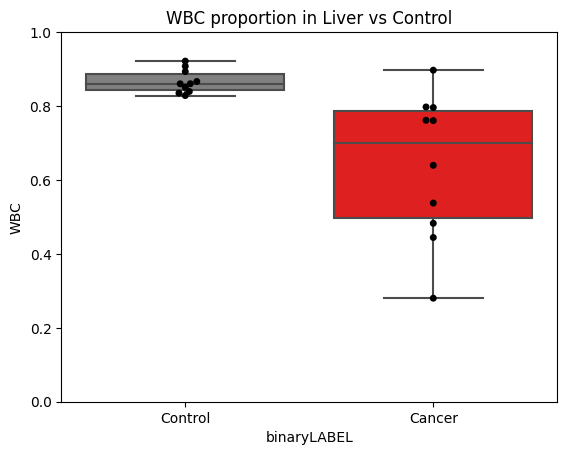

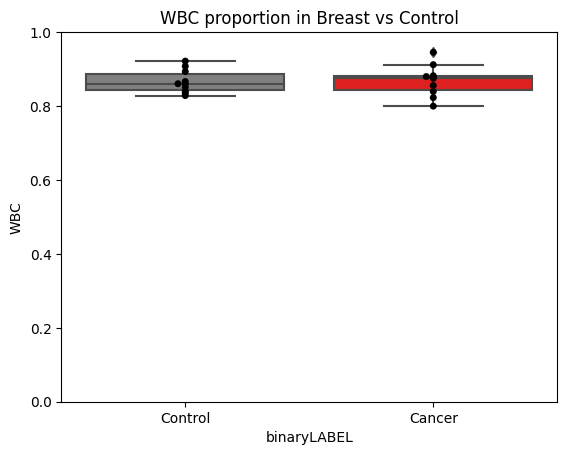

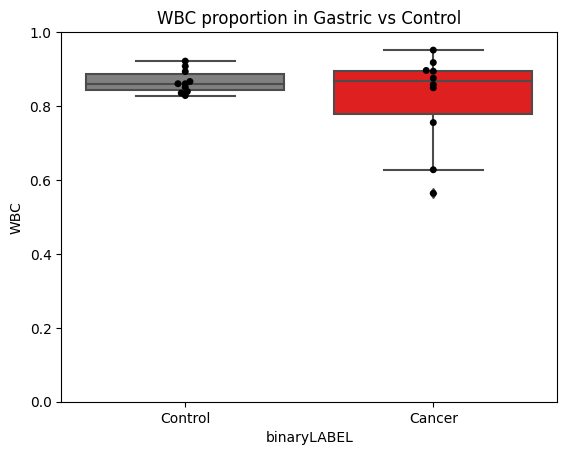

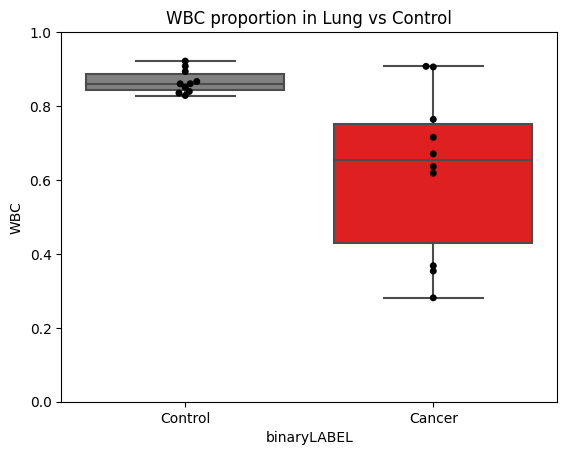

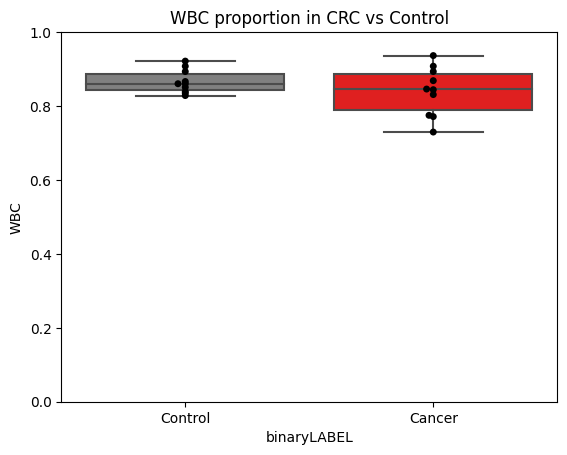

In [22]:
for input_class in ["Liver", "Breast", "Gastric", "Lung", "CRC"]:
    subset = resdf[resdf["TYPE"].isin([input_class, "Control"])].copy()
    # ensure binaryLABEL has a consistent order
    subset["binaryLABEL"] = pd.Categorical(subset["binaryLABEL"], categories=["Control", "Cancer"], ordered=True)

    sns.boxplot(
        data=subset,
        x="binaryLABEL",
        y="WBC",
        palette={"Control": "gray", "Cancer": "red"},
        order=["Control", "Cancer"]
    )
    sns.swarmplot(
        data=subset,
        x="binaryLABEL",
        y="WBC",
        color="black",
        order=["Control", "Cancer"]
    )
    plt.title(f"WBC proportion in {input_class} vs Control")
    plt.ylim(0, 1)
    plt.show()